# Option Quotations Loader

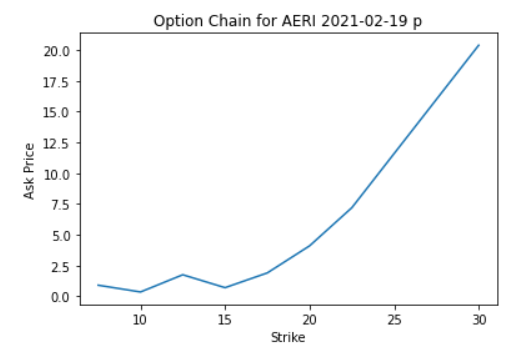

In [1]:
import mysql.connector
import pymysql
import pymysql.cursors
import pdb
import datetime
import time
import pytz
import json
import requests
import calendar
import matplotlib.pyplot as plt 

In [2]:
# Set Up the connection to the database
conn = pymysql.connect(host = '127.0.0.1', user='root', password = 'piet', db = 'invest', cursorclass = pymysql.cursors.DictCursor)
cursor = conn.cursor(pymysql.cursors.DictCursor)

#Initialise the date & time so that we can store in the records; quotes should be timestamped, the query timestamp is important for future tracking
nowdate = datetime.date.today()
nowdatetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#loop for both calls and puts
optiontypes = ['calls','puts']

#Get option quotes for these tickers; alternatively, select the list from another table or data source
#ticklist = [{'tick': 'MSFT'}, {'tick': 'AAPL'}]
ticklist = [{'tick': 'AERI'}]

AERI
1613692800  2021-02-19 01:00:00


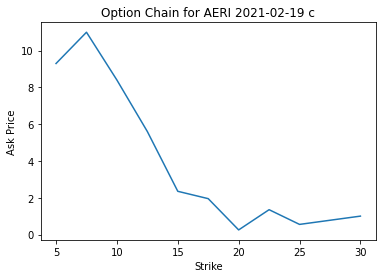

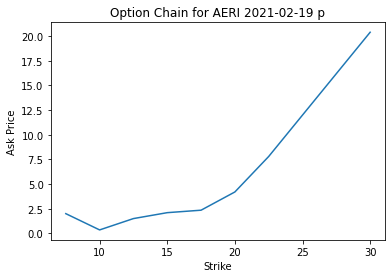

1616112000  2021-03-19 01:00:00


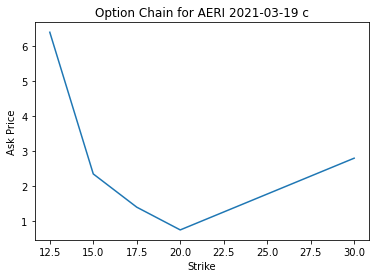

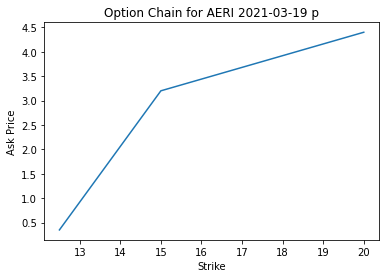

1621555200  2021-05-21 02:00:00


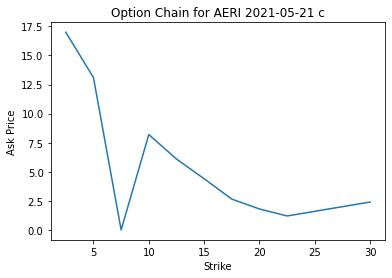

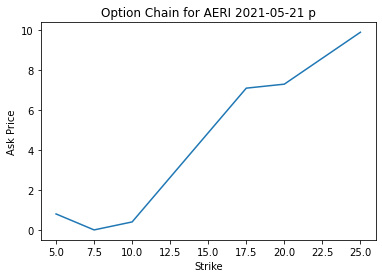

1629417600  2021-08-20 02:00:00


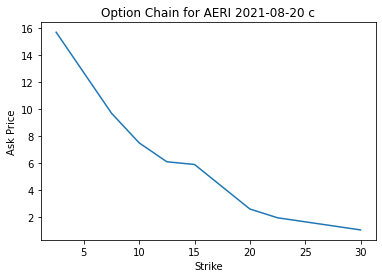

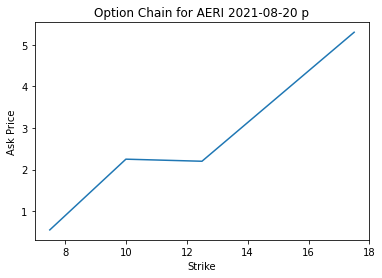

In [3]:
#loop through all ticker symbols, get the option quotations for each symbol
for mytick in ticklist:

    symbol = mytick['tick']
    print(symbol)

    #Get the expirationdates, using these yahoo services:
    #https://query1.finance.yahoo.com/v7/finance/options/AAPL                   gives all expirations for Options on AAPL
    #https://query2.finance.yahoo.com/v7/finance/options/AAPL?date=1537488000   gives all expirations for one single strike date for Options on AAPL
    #https://finance.yahoo.com/quote/AAPL/key-statistics?p=AAPL                 gives key fundamentals as a web page, and also in JSON format-->
    #https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAPL?formatted=true&lang=en-US&region=US&modules=defaultKeyStatistics%2CfinancialData%2CcalendarEvents&corsDomain=finance.yahoo.com
    url='https://query2.finance.yahoo.com/v7/finance/options/' + symbol
    response = requests.get(url)
    #load the raw json data into a python data object
    data = response.json()

    #avoid loading empty data
    if len(data['optionChain']['result']) == 0:
        print('No options for: ' + symbol)
        break  #to exit a loop use break or to stop execution without the interpreter use https://stackoverflow.com/questions/28413104/stop-python-script-without-killing-the-python-process


    #Loop through the expiration dates; request the option details iteratively in the loop
    for i in data['optionChain']['result'][0]['expirationDates']:
        
        #The yahoo json response provides dates in UNIX date-time format --> convert where necessary
        print (str(i) + '  ' + datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d %H:%M:%S'))

        #this is the 'magic' URL that responds with all option quotations for the given ticker and expiration date
        url_date='https://query2.finance.yahoo.com/v7/finance/options/' + symbol + '?date=' + str(i)
        response_date = requests.get(url_date)
        data_date = response_date.json() #data_date contains all JSON data for one given expiration date
        
        #avoid loading empty data
        if data_date['optionChain']['result'] == 'null':
            print('EMPTY RETURN for one experation date:  ' + symbol + '  ' + datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d %H:%M:%S'))
        else:
            #print('index:' + ' ' + str(data_date['optionChain']['result'][0]['options'])) - debug line
            #now process the response and store it in the database as clean separate records
            #loop first through all calls then through all puts
            for callputloop in optiontypes:
                #Loop through each of the strike values for the given expiration date
                x = []
                y = []
                #First avoid empty strike records
                if len(data_date['optionChain']['result'][0]['options'][0][callputloop]) == 0:
                    print('EMPTY RETURN ' + symbol + str(i) + ' ' + datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d %H:%M:%S')
                          + 'strike: ' + str(mystrike['strike']) + ' C/P: ' + callputloop[0])
                    break  #to exit a function use return or to exit a loop use break or to stop the script use exit() or to stop
                for mystrike in data_date['optionChain']['result'][0]['options'][0][callputloop]:
                    myexpir_date = (datetime.datetime.fromtimestamp(mystrike['expiration'])).date()

                    #print(mystrike['strike'],mystrike['lastTradeDate']) - debug line
                    if mystrike['lastTradeDate'] > 0:
                        mylastTradeDate = (datetime.datetime.fromtimestamp(mystrike['lastTradeDate'])).date()
                        #now we do the actual insert of the option quotation, together with all available details
                        cursor.execute(""" INSERT INTO option_table1
                        (tick, ATREQ_date,
                        ATREQ_stockprice_fromchain,
                        strike, ATREQ_ask,ATREQ_bid, expdate,callput,
                        ATREQ_optLastPrice,ATREQ_LastTradeDate,ATREQ_openint)
                        VALUES ( %s,%s,
                        %s,
                        %s,%s,%s,%s,%s,
                        %s,%s,%s )
                        """,
                       (symbol,nowdate,
                        round(data_date['optionChain']['result'][0]['quote']['regularMarketPrice'],3),
                        mystrike['strike'],mystrike['ask'],mystrike['bid'],myexpir_date,callputloop[0],
                        mystrike['lastPrice'],mylastTradeDate,mystrike['openInterest']))
                        x.append([mystrike['strike']])  
                        y.append([mystrike['ask']])
                plt.plot(x, y) 

                plt.xlabel('Strike') 
                plt.ylabel('Ask Price') 
                plt.title('Option Chain for '+symbol+ ' ' + str(myexpir_date)+ ' ' + callputloop[0]) 
                plt.show() 

            # commit the insert for each (symbol,expiration date) combo
            conn.commit()

In [4]:
cursor.close()
conn.close()